<a href="https://colab.research.google.com/github/Tyanakai/medical_paper_classification/blob/main/medical_bert_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>医学論文の自動仕分けチャレンジ 訓練</h1>


# １. はじめに

本ノートブックでは、SIGNATE上で開催された文章分類コンペティション[医学論文の自動仕分けチャレンジ](https://signate.jp/competitions/471)のタスクに基づいて、BERTモデルを訓練します。<br>
データは[medical_EDA.ipynb](https://github.com/Tyanakai/medical_paper_classification/blob/main/medical_EDA.ipynb)において前処理し保存したファイル(`p_train.csv`,`p_test.csv`)を使用します。<br>
使用するモデルは、以下の通りです。
<br>

*   [BioELECTRA](https://github.com/kamalkraj/BioELECTRA)
*   [SapBERT](https://huggingface.co/cambridgeltl/SapBERT-from-PubMedBERT-fulltext)
*   [PubMedBERT](https://huggingface.co/microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext)
*   [BioBERT](https://huggingface.co/dmis-lab/biobert-base-cased-v1.2)

尚、colabratory上で、ランタイムのタイプをTPUに設定した状態での実行を想定しています。

# ２. 事前に完了していること

- [medical_EDA.ipynb](https://github.com/Tyanakai/medical_paper_classification/blob/main/medical_EDA.ipynb)を実行

# ３. 環境準備
訓練環境を構築します。

## 3.1 ライブラリ準備

In [1]:
! pip install -q transformers
! pip install -q tensorflow-addons

import datetime
import json
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import transformers

# warnings.filterwarnings("ignore")

## 3.2 TPU設定

In [2]:
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', TPU.cluster_spec().as_dict()['worker'])
except ValueError:
    TPU = None
    print('INFO: Not connected to a TPU runtime')

Running on TPU  ['10.38.49.226:8470']


## 3.3 Google Driveマウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

## 3.4 ハイパーパラメータ設定
ハイパーパラメータを設定します。

|パラメータ名|説明|
|:-|:-|
|model| Hugging Face内のパス。ローカルフォルダやファイルの命名にも用いる|
|from_pt|tf_model.h5が公開されていない場合、Trueとする|
|encode_type|encoderの出力形式。cf.) 4.1 model定義|
|-|-|
|max_length|入力する最大token数|
|opt|使用するscipy.optimizeのアルゴリズム|
|patience|EarlyStoppingのパラメータ。訓練早期終了を延期するepoch数|
|check_monitor|ModelCheckpointのパラメータ。保存するmodelの選定指標|
|check_mode|check_monitorでval_aucを選択した場合"max"でないと正常に機能しない
|-|-|
|loss_fn|損失関数。"bce" : binary crossentropy, "focal" : focal binary crossentropy| 
|loss_weight|loss_fnをweighted_bceにした場合、負例、正例にそれぞれ乗算する重みを設定する|
|class_weight|model.fit()時にclass別に重みを乗算する。loss_weightと同時に使用しない。cf.) 6.4 class weight|
|-|-|
|target_col|判定するラベル列|
|text_col|入力として用いる列|
|-|-|
|temp_thre|仮の閾値|
|-|-|
|time_jp|日本標準時。ファイル名を区別するために使用|



In [4]:
class Config:
    model = "dmis-lab/biobert-base-cased-v1.2" #@param
    from_pt = True #@param {"type":"boolean"}
    encode_type = "cls_cat" #@param {"type","string"} ["cls","cls_cat","pooler","logits", "last_hidden_state_cnn", "last_hidden_state_lstm"]

    max_length = 512 #@param {"type":"integer"}
    lr = 0.00002
    weight_decay = 1e-5
    opt = "minimize"  #@param {"type":"string"} ["minimize_scalar","minimize"]
    n_fold = 5 #@param
    epochs = 15 #@param {"type":"slider"}
    patience = 4 #@param
    check_monitor = "val_fbeta_score" #@param {"type":"string"} ["val_loss","val_fbeta_score","val_auc"]
    check_mode = "max" #@param {"type":"string"} ["auto", "max"]
    
    train_batch_size = 64 #@param {"type":"raw"} [4,8,16,32,64]
    valid_batch_size = 64 #@param {"type":"raw"} [4,8,16,32,64]
    test_batch_size = 64 #@param {"type":"raw"} [4,8,16,32,64]
    steps_per_epochs = None #(27145 * (n_fold - 1) / n_fold) // train_batch_size
    train_file = "p_train.csv" #@param
    test_file = "p_test.csv" #@param
    target_col = "judgement"
    text_col = "text"
    seeds = [21]

    loss_fn = "bce" #@param {"type":"string"} ["bce", "weighted_bce", "focal"]
    loss_weight = [1, 50] #@param
    class_weight = "balanced" #@param {"type":"raw"}     
    label_smoothing = 0 #@param
    
    submit = True #@param {"type":"boolean"}
    debug = True  #@param {"type":"boolean"}
    temp_thre = 0.1 #@param

if Config.debug:
    Config.epochs = 2
    Config.n_fold = 2

time_jp = (datetime.datetime.now() + 
           datetime.timedelta(hours=9)).strftime('%Y%m%d_%H%M')
# time_jp = '20210926_1749' #@param
time_jp

'20211102_2135'

## 3.5 pathの設定
pathを設定し必要なフォルダを作成します。

In [32]:
DRIVE = "/content/drive/MyDrive/signate/medical_paper"
INPUT = os.path.join(DRIVE, "input")
OUTPUT = os.path.join(DRIVE, "output")
LOG = os.path.join(OUTPUT, f"{Config.model.replace('/','-')}_tf")
MODEL = os.path.join(DRIVE, "model", f"{Config.model.replace('/','-')}_tf")
SUBMIT = os.path.join(DRIVE, "submit") # 提出ファイルを保存するフォルダ
PROB = os.path.join(DRIVE, "prob") # 予測確率値(probability)を保存するフォルダ

for folder in [DRIVE, INPUT, OUTPUT, LOG, MODEL, SUBMIT, PROB]:
    os.makedirs(folder, exist_ok=True)

## 3.6 loggingの設定

In [6]:
class Logger:
    """
    log を残す用のクラス
    path : logを保存するフォルダ 
    """
    def __init__(self, path):
        self.general_logger = logging.getLogger(__name__)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, f'Experiment{time_jp}.log'))
        if len(self.general_logger.handlers) == 0:
            # self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # 時刻とmessageを記録
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        # 時刻を取得
        cur_time = datetime.datetime.now() + datetime.timedelta(hours=9)
        return cur_time.strftime('%Y-%m-%d %H:%M:%S')

logger = Logger(LOG)

# ４. model, tokenizer準備
訓練するmodelやtokenizerを取得する関数を定義します。

## 4.1 model定義

In [7]:
def build_encoder():
    """
    encoderの出力形式(Config.encode_type)に従って
    設定を変化させたencoderを返します。
    """
    if Config.encode_type == "logits":
        encoder = (
            transformers
            .TFAutoModelForSequenceClassification
            .from_pretrained(Config.model, num_labels=1, from_pt=Config.from_pt)
        )

    elif Config.encode_type == "cls_cat":
        # 最終層以外のhidden_statesを出力する為のconfig
        config = (
            transformers.
            AutoConfig.
            from_pretrained(Config.model, output_hidden_states=True)
        )

        encoder = (
            transformers
            .TFAutoModel
            .from_pretrained(Config.model, config=config, from_pt=Config.from_pt)
        )

    else:
        encoder = (
            transformers
            .TFAutoModel
            .from_pretrained(Config.model, from_pt=Config.from_pt)
        )

    return encoder


def neural_networks(x):
    """
    encoderの出力形式(Config.encode_type)に従って
    encoder以降の構造を定義します。
    """

    if Config.encode_type == "cls":
        # cls tokenを使用
        x = x[0][:, 0, :]
        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    elif Config.encode_type == "cls_cat":
        # encoderの最終四層分のcls tokenを連結
        x = tf.concat([x["hidden_states"][-i][:,0,:] for i in range(1,5)], axis=-1)
        x = tf.keras.layers.Dropout(0.2)(x)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    elif Config.encode_type == "pooler":
        x = x["pooler_output"]
        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    elif Config.encode_type == "logits":
        # TFAutoModelForSequenceClassificationの出力
        x = x["logits"]
        output = tf.keras.layers.Activation("sigmoid")(x)

    elif Config.encode_type == "last_hidden_state_cnn":
        # encoderの最終出力を１次元のCNNで処理
        x = x["last_hidden_state"]
        x = tf.keras.layers.Conv1D(
            256, kernel_size=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.Conv1D(
            1, kernel_size=2, padding="same")(x)
        x = tf.keras.layers.GlobalMaxpooling1D()(x)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
    elif Config.encode_type == "last_hidden_state_lstm":
        # encoderの最終出力を双方向LSTMで処理
        x = x["last_hidden_state"]
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(728))(x)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return output


def build_model():
    """
    使用するkerasモデルの全体像を定義します。
    """
    # encoder
    encoder = build_encoder()

    # 入力
    input_ids = tf.keras.layers.Input(shape=(Config.max_length, ), 
                                           dtype=tf.int32, 
                                           name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(Config.max_length, ),
                                           dtype=tf.int32, 
                                           name='attention_mask')
    
    # ニューラルネットワーク全体構造
    x = encoder(input_ids=input_ids, 
                attention_mask=attention_mask, 
                output_hidden_states=True)
    output = neural_networks(x)

    # kerasモデル化
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask],
                                  outputs=[output])

    # 最適化アルゴリズムと損失関数
    optimizer = tfa.optimizers.AdamW(lr=Config.lr, weight_decay=Config.weight_decay)
    loss = {"bce": tf.keras.losses.BinaryCrossentropy(),
            "weighted_bce": weighted_binary_crossentropy(Config.loss_weight, Config.label_smoothing),
            "focal": tfa.losses.SigmoidFocalCrossEntropy(alpha=0.98, gamma=2.0),
            "mse": tf.keras.losses.MeanSquaredError()}

    # 訓練中監視する指標
    metrics = [tfa.metrics.FBetaScore(num_classes=1,
                                      beta=6.0,
                                      threshold=Config.temp_thre),
               tf.keras.metrics.AUC(num_thresholds=200, curve='PR',
                                    multi_label=False, label_weights=None)]

    model.compile(optimizer=optimizer,
                  loss=loss[Config.loss_fn], 
                  metrics=metrics)
    # model.summary()
    return model

## 4.2 model取得
環境に合わせてmodelを構築し取得します。


In [8]:
def get_model():
    """
    modeを取得
    """
    if TPU:
        tf.config.experimental_connect_to_cluster(TPU)
        tf.tpu.experimental.initialize_tpu_system(TPU)
        tpu_strategy = tf.distribute.TPUStrategy(TPU)
        with tpu_strategy.scope():
            model = build_model()
    else:
        model = build_model()

    return model

# ５. データ準備
データをロードし、加工する為の関数を定義します。

In [9]:
def get_data(file_name):
    """
    csvファイルをロードし、前処理する。
    """
    df = pd.read_csv(os.path.join(INPUT, file_name))
    if Config.debug:
        df = df.sample(256, random_state=Config.seeds[0]).reset_index(drop=True)

    # 前処理
    df["text"] = df["title"] + " " + df["abstract"].fillna("")
    return df


def skf(train_df, n_splits, random_state):
    """
    層化K分割したindexのリストを返す。
    n_splits<=1 の場合、全indexを返す。
    """
    if n_splits > 1:
        skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        return list(skf.split(train_df, train_df[Config.target_col]))
    else:
        return train.index


def tokenize_texts(texts, tokenizer):
    """
    バッチ化された文字列をtoken化し、
    keyが"input_ids"と"attention_mask"の辞書として返す。
    """
    tokenized_dict = tokenizer.batch_encode_plus(
        texts,
        padding='max_length',
        truncation=True,
        max_length=Config.max_length,
        return_token_type_ids=False,
    )
    return dict(tokenized_dict)


def get_dataset(x, y=None, dataset="test"):
    """
    データをtf.data.Datasetの形式に変換する。
    """
    if dataset=="train":
        tr_ds = tf.data.Dataset.from_tensor_slices((x, y))
        if Config.steps_per_epochs is not None:
            tr_ds = tr_ds.repeat()
        tr_ds = tr_ds.shuffle(2048)
        tr_ds = tr_ds.batch(Config.train_batch_size)
        tr_ds = tr_ds.prefetch(tf.data.experimental.AUTOTUNE)
        return tr_ds

    elif dataset=="valid":
        val_ds = tf.data.Dataset.from_tensor_slices((x, y))
        val_ds = val_ds.batch(Config.valid_batch_size)
        val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
        return val_ds
    
    elif dataset=="test":
        test_ds = tf.data.Dataset.from_tensor_slices(x)
        test_ds = test_ds.batch(Config.test_batch_size)
        test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)
        return test_ds

# ６. 訓練準備
model訓練時に必要な関数を定義します。

## 6.1 カスタム損失関数
自作の損失関数を定義します。

In [10]:
def weighted_binary_crossentropy(weight, label_smoothing):
    """
    負例、正例にそれぞれ異なる重み付けをするcrossentropy損失関数
    """
    weight = tf.convert_to_tensor(weight, dtype=tf.float32)

    def _weighted_binary_crossentropy(target, output):
        """
        label smoothingに対応した一般的なcrossentropy損失関数
        keras公式の実装を参考に実装

        """
        if Config.label_smoothing:
            target = target * (1.0 - label_smoothing) + 0.5 * label_smoothing
        target = tf.convert_to_tensor(target, dtype=tf.float32)
        target = tf.reshape(target, [-1])

        output = tf.convert_to_tensor(output, dtype=tf.float32)
        output = tf.reshape(output, [-1])
        epsilon_ = K.epsilon()
        output = tf.clip_by_value(output, epsilon_, 1. - epsilon_)

        bce = weight[1] * target * tf.math.log(output + K.epsilon())
        bce += weight[0] * (1 - target) * tf.math.log(1 - output + K.epsilon())
        return -bce

    return _weighted_binary_crossentropy

## 6.2 閾値最適化アルゴリズム
閾値の最適化に必要な関数を定義します。

In [11]:
def opt_fbeta_threshold(y_true, y_pred):
    """
    閾値のfbeta score最適化アルゴリズム
    """
    def opt_(x): 
        return -fbeta_score(y_true, y_pred>=x, beta=7)
    if Config.opt == "minimize":
        result = minimize(opt_, x0=np.array([0.1]), method="Powell")
    elif Config.opt == "minimize_scalar":
        result = minimize_scalar(opt_, bounds=(0.001, 0.85), method='bounded')
    opted_threshold = result['x'].item()
    return opted_threshold

## 6.3 訓練結果
訓練結果を取得したり表示する為の関数です。

In [12]:
def metrics(y_true, y_pred):
    """
    最適化された閾値とその時のfbeta scoreを取得する。
    """
    opted_thre = opt_fbeta_threshold(y_true, y_pred)
    print(f"opted threshold : {opted_thre}")
    score = fbeta_score(y_true, y_pred >= opted_thre, beta=7)
    return score, opted_thre


def get_result(y_true, y_pred, thresholds=None):
    """
    様々な閾値とその時のfbetaスコアをpd.DataFrameとして返す。

    1.　閾値のlistが与えられなかった場合
    仮の閾値(Config.temp_thre)、最適化した閾値と
    それらに対応するfbetaスコアを計算し、pd.DataFrameに格納する。

    2.　閾値のlistが与えられた場合
    その最大値、最小値、平均値、中央値と
    それらに対応するfbetaスコアを計算し、上に追加する。
    """
    thre_df = pd.DataFrame(columns=["threshold", "score"])

    naive_score = fbeta_score(y_true, y_pred >= Config.temp_thre, beta=6.0)
    opted_score, opted_thre = metrics(y_true, y_pred)
    type_list = ["opted", "temporary"]
    thre_list = [opted_thre, Config.temp_thre]
    score_list = [opted_score, naive_score]

    if type(thresholds) is list:
        thresholds = np.array(thresholds)
        min_thre = thresholds.min()
        max_thre = thresholds.max()
        mean_thre = thresholds.mean()
        med_thre = np.median(thresholds)

        min_score = fbeta_score(y_true, y_pred >= min_thre, beta=6.0)
        max_score = fbeta_score(y_true, y_pred >= max_thre, beta=6.0)
        mean_score = fbeta_score(y_true, y_pred >= mean_thre, beta=6.0)
        med_score = fbeta_score(y_true, y_pred >= med_thre, beta=6.0)

        type_list += ["min", "max", "mean","median"]
        thre_list += [min_thre, max_thre, mean_thre, med_thre]
        score_list += [min_score, max_score, mean_score, med_score] 

    thre_df["threshold"] = thre_list
    thre_df["score"] = score_list
    thre_df.index = type_list
    return thre_df


def visualize_confusion_matrix(
        y_true,
        pred_label,
        height=.6,
        labels=None):
    """
    混合行列を表示する。
    """
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    return fig

## 6.4 class weight
model.fit()の引数：class_weightに渡す値を取得します。<br>
model.fit()は、学習時にはclass_weightに従ってlossに重みを乗算しますが、<br>
検証データ評価時には、適用しないので、指標のval_lossは重みが乗算された値となりません。<br>
故に、もしval_lossにも重み付けをする場合、損失関数は前述のweighted_binary_crossentropyを使用します。

In [13]:
def get_class_weight(target, weight):
    """
    class weightを取得する。
    """
    if weight == "balanced":
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(target),
            y=target)
        class_weights = dict(enumerate(class_weights))
    elif weight is None:
        class_weights = None
    else:
        # ex) weight = {0:0.2, 1:0.98}
        class_weights = weight
    
    return class_weights

## 6.5 訓練関数、推論関数
訓練、推論部分の手順を定義します。

In [14]:
def train_fn(train_df, valid_df, model, tokenizer, filepath):
    """
    訓練関数
    """
    # tf.data.Dataset準備
    tr_text = tokenize_texts(texts=train_df[Config.text_col].tolist(), 
                             tokenizer=tokenizer)
    val_text = tokenize_texts(texts=valid_df[Config.text_col].tolist(),
                              tokenizer=tokenizer)

    tr_ds = get_dataset(x=tr_text, 
                        y=train_df[Config.target_col].values, 
                        dataset="train")
    val_ds = get_dataset(x=val_text, 
                         y=valid_df[Config.target_col].values, 
                         dataset="valid")

    # callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor=Config.check_monitor, 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True,
        mode=Config.check_mode
        )
    
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=Config.patience
        )
    
    # 訓練実行
    history = model.fit(
        tr_ds, 
        epochs=Config.epochs, 
        verbose=1, 
        callbacks=[checkpoint, earlystop],
        validation_data=val_ds, 
        steps_per_epoch=Config.steps_per_epochs,
        class_weight=get_class_weight(train_df[Config.target_col], 
                                      weight=Config.class_weight)
        )
    
    return history


def inference_fn(test_df, model, tokenizer, filepath):
    """
    推論関数
    """
    model.load_weights(filepath)
    te_text = tokenize_texts(texts=test_df[Config.text_col].tolist(), 
                             tokenizer=tokenizer)
    te_ds = get_dataset(x=te_text, y=None, dataset="test")
    preds = model.predict(te_ds)
    return preds.reshape(-1)

## 6.6 交差検証関数
cross validationの手順を定義します。

In [29]:
def train_cv(train_df, kf, metrics, name, dir):
    """
    cross validationの実行関数 (train)
    """
    # oofの予測確率(probability)と最適化された閾値の保存領域
    oof_preds = np.zeros(len(train_df))
    threshold_list = []

    # k分割訓練
    for i_fold, (tr_idx, val_idx) in enumerate(kf):
        K.clear_session()
        print(f"\n===== FOLD {i_fold+1} training =====")
        filepath = os.path.join(dir, f"{name}_fold{i_fold+1}.h5")

        # model, tokenizerの準備
        model = get_model()
        tokenizer = transformers.AutoTokenizer.from_pretrained(Config.model)

        # dataの分割
        tr_df = train_df.iloc[tr_idx].reset_index()
        val_df = train_df.iloc[val_idx].reset_index()
        
        # 学習済みモデルがあれば訓練しない
        if not os.path.isfile(filepath):
            history = train_fn(tr_df, val_df, model, tokenizer, filepath)
            pd.DataFrame(history.history).to_csv(
                os.path.join(LOG, f"history{time_jp}_{i_fold+1}.csv"), 
                index=False)

        # oofの予測確率を計算し、
        # 最適化された閾値とスコアをpd.DataFrameとして取得
        preds = inference_fn(val_df, model, tokenizer, filepath)
        thre_df = get_result(val_df[Config.target_col], preds)

        # 最適化された閾値
        opted_thre = thre_df[thre_df.index=="opted"].threshold.values[0]

        logger.info(f"===== fold {i_fold+1} result =====")
        logger.info(f">>> {thre_df.to_dict()}")

        # oofの予測確率値と最適化された閾値を保存
        oof_preds[val_idx] = preds
        threshold_list.append(opted_thre)
    
    # oof全体の最適な閾値と、threshold_listから得た閾値でスコアを計算
    thre_df = get_result(train_df[Config.target_col], oof_preds, threshold_list)
    logger.info(f"===== total result =====")
    logger.info(f">>> threshold:{thre_df.to_dict()['threshold']}")
    logger.info(f">>> score:{thre_df.to_dict()['score']}")
    return oof_preds, threshold_list


def predict_cv(test_df, name):
    """
    cross validationの実行関数 (test)
    fold毎に保存したそれぞれのモデルでtestファイルに対し
    probabilityを予測し、平均する
    """
    preds_fold = []
    for i_fold in range(Config.n_fold):
        filepath = os.path.join(MODEL, f"{name}_fold{i_fold+1}.h5")
        model = get_model()
        tokenizer = transformers.AutoTokenizer.from_pretrained(Config.model)

        preds = inference_fn(test_df, model, tokenizer, filepath)
        preds_fold.append(preds)

        logger.info(f"===== fold{i_fold+1} inference =====")
    
    preds = np.mean(preds_fold, axis=0)
    return preds

# ７. 提出準備
交差検証訓練の結果得た様々な閾値で、提出ファイルを作成する関数を定義します。

In [16]:
def submit_with_thresholds(type_list, threshold_list):
    """
    様々な閾値を用いて、submitファイルを作成、保存
    """
    name = f"{Config.model.replace('/','-')}_{time_jp}"
    # testファイルに対して予測したprobability
    prob_df = pd.read_csv(os.path.join(PROB, f"prob_{name}.csv"))
    # submitファイルの雛形
    submit_df = pd.read_csv(os.path.join(INPUT, "sample_submit.csv"), 
                            header=None, 
                            names=["id", "judgement"])
    if Config.debug:
        submit_df = submit_df.iloc[get_data(Config.test_file).index.values]
        
    # submit
    for key, threshold in zip(type_list, threshold_list):
        predictions = (prob_df[f"{name}_seed{Config.seeds[0]}"].values >= threshold) * 1
        filepath = f"{name}_{key}.csv"
        submit_df["judgement"] = predictions
        submit_df.to_csv(os.path.join(SUBMIT, filepath), 
                         index=False, 
                         header=False)
        logger.info(f"saved file : {name}_{key}.csv")

# ８. 実行
全体の手順を定義し、実行します。

In [33]:
def main():
    # 訓練ごとに異なるファイル名を作成
    model_name = f"{Config.model.replace('/','-')}_{time_jp}"
    logger.info(f"{model_name} TRAINING")

    # data準備
    train_df = get_data(Config.train_file)
    test_df = get_data(Config.test_file)

    # 設定したseeds毎に訓練
    oof_df = pd.DataFrame()
    threshold_list = []
    for seed in Config.seeds:
        name = f"{model_name}_seed{seed}"
        logger.info(f"***** SEED{seed} *****")
        oof_preds, seed_thre_list = train_cv(
            train_df, 
            kf=skf(train_df, n_splits=Config.n_fold, random_state=seed),
            metrics=metrics, 
            name=name, 
            dir=MODEL)
        oof_df[name] = oof_preds
        threshold_list += seed_thre_list

    # oofの予測値(probability)を保存
    oof_df.to_csv(os.path.join(PROB, f"oof_{model_name}.csv"), index=False)
    logger.info(f"saved file : oof_{model_name}.csv")

    # トータルスコアを記録
    y_true = train_df[Config.target_col].values
    y_pred = oof_df.mean(axis=1).values
    thre_df = get_result(y_true, y_pred, threshold_list)
    
    logger.info(f"***** seeds total result *****")
    logger.info(f">>> threshold:{thre_df.to_dict()['threshold']}")
    logger.info(f">>> score:{thre_df.to_dict()['score']}")

    # 最適閾値で混合行列を表示
    opted_thre = thre_df[thre_df.index=="opted"].threshold.values[0]
    fig = visualize_confusion_matrix(y_true, y_pred>=opted_thre)
    fig.savefig(os.path.join(LOG, f"cm_{time_jp}.png"), dpi=300)

    # test予測値(probability)を計算
    preds_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{model_name}_seed{seed}"
        preds = predict_cv(test_df, name)
        preds_df[name] = preds

    # test予測値(probability)を保存
    preds_df.to_csv(os.path.join(PROB, f"prob_{model_name}.csv"), index=False)  
    logger.info(f"saved file : prob_{name}.csv")

    # submit
    if Config.submit:
        submit_with_thresholds(thre_df.index, thre_df.threshold)

    # ハイパーパラメーターとkeras.modelの構造を記録
    code_text = ""
    with open(os.path.join(DRIVE, "medical_bert_tf.ipynb"), mode="r") as f:
        code = f.read()

    for i in [2,3]:
        code_text += "".join(json.loads(code)["cells"][i]["source"])+"\n\n"

    logger.info(code_text)

INFO:__main__:[2021-11-02 22:06:16] - dmis-lab-biobert-base-cased-v1.2_20211102_2135 TRAINING
INFO:__main__:[2021-11-02 22:06:17] - ***** SEED21 *****



===== FOLD 1 training =====
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights o

opted threshold : -1.4994280624162823

===== FOLD 2 training =====
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights o

opted threshold : 0.14460922713941426
opted threshold : 0.14461537636747432


INFO:__main__:[2021-11-02 22:09:45] - saved file : oof_dmis-lab-biobert-base-cased-v1.2_20211102_2135.csv
INFO:__main__:[2021-11-02 22:09:45] - ***** seeds total result *****
INFO:__main__:[2021-11-02 22:09:45] - >>> threshold:{'opted': 0.14461537636747432, 'temporary': 0.1, 'min': -1.4994280624162823, 'max': 0.14460922713941426, 'mean': -0.677409417638434, 'median': -0.677409417638434}
INFO:__main__:[2021-11-02 22:09:45] - >>> score:{'opted': 0.7208387942332897, 'temporary': 0.6319875776397516, 'min': 0.6242331288343558, 'max': 0.6564516129032257, 'mean': 0.6242331288343558, 'median': 0.6242331288343558}


opted threshold : 0.14461537636747432


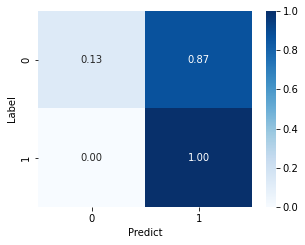

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights o

INFO:__main__:[2021-11-02 22:11:22] - ===== fold1 inference =====


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.49.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights o

INFO:__main__:[2021-11-02 22:13:47] - ===== fold2 inference =====
INFO:__main__:[2021-11-02 22:13:47] - saved file : prob_dmis-lab-biobert-base-cased-v1.2_20211102_2135_seed21.csv
INFO:__main__:[2021-11-02 22:13:48] - saved file : dmis-lab-biobert-base-cased-v1.2_20211102_2135_opted.csv
INFO:__main__:[2021-11-02 22:13:48] - saved file : dmis-lab-biobert-base-cased-v1.2_20211102_2135_temporary.csv
INFO:__main__:[2021-11-02 22:13:48] - saved file : dmis-lab-biobert-base-cased-v1.2_20211102_2135_min.csv
INFO:__main__:[2021-11-02 22:13:48] - saved file : dmis-lab-biobert-base-cased-v1.2_20211102_2135_max.csv
INFO:__main__:[2021-11-02 22:13:48] - saved file : dmis-lab-biobert-base-cased-v1.2_20211102_2135_mean.csv
INFO:__main__:[2021-11-02 22:13:48] - saved file : dmis-lab-biobert-base-cased-v1.2_20211102_2135_median.csv
INFO:__main__:[2021-11-02 22:13:48] - class Config:
    model = "dmis-lab/biobert-base-cased-v1.2" #@param
    from_pt = True #@param {"type":"boolean"}
    encode_type = "

In [34]:
main()